<div class="head0">
    <div class="head0__name">
        Custom ODE solvers
    </div>
    <div class="head0__note">
        Solution of the ordinary differential equation (ODE) with multiple initial conditions by standard Euiler and the 4th order Runge-Kutta method.
    </div>
</div>

In [1]:
import sys
import time

import numpy as np
from scipy.integrate import solve_ivp
import matplotlib as mpl
import matplotlib.pyplot as plt

sys.path.extend(['./../lib', './../helpers'])
from intertrain import Intertrain
from solver import Solver
from config import config

names = ['eul', 'rk4', 'ivp']

l1 = config['opts']['plot']['line']['l1'].copy()
l1['label'] = names[0]
l2 = config['opts']['plot']['line']['l2'].copy()
l2['label'] = names[1]
l3 = config['opts']['plot']['line']['l3'].copy()
l3['label'] = names[2]
l4 = config['opts']['plot']['line']['l4'].copy()
l4['label'] = 'Appr'
l5 = config['opts']['plot']['line']['l5'].copy()
l5['label'] = 'Appr'

from helpers import init_jupyter; init_jupyter()

Start | 10:27AM MSK on Sep 19, 2019 |
-------------------------------------


<div class="head1">
    <div class="head1__name">
        Test 1D
    </div>
</div>

Consider
$$
    d r = f(r, t) \, d t,
    \quad
    r \in R^{1},
    \quad
    r(0) = r_0,
    \quad
    f(r, t) = r^2,
$$
with known analytic solution
$$
    r(t) = \frac{r_0}{1 - r_0 t}.
$$

In [2]:
def func_f0(r, t):
    return r*r

def func_rt(t):
    return r0 / (1. - r0 * t)

In [3]:
d = 1
t_min = 0.
t_max = 0.0001
t_poi = 2
r0 = -2.5 * np.arange(1000).reshape(1, -1) + 0.2

r_real = func_rt(t_max)

In [4]:
for name in names:
    _t = time.time()
    r_calc = eval('Solver.ode_solve_' + name)(func_f0, r0, t_min, t_max, t_poi)
    _e = np.mean(np.abs((r_real - r_calc) / r_real))
    print('Solver: "%s" | Err: %-8.2e | Time: %-8.2e'%(name, _e, time.time() - _t))

Solver: "eul" | Err: 2.08e-02 | Time: 1.71e-04
Solver: "rk4" | Err: 3.29e-06 | Time: 1.23e-03
Solver: "ivp" | Err: 1.39e-06 | Time: 2.26e-01


In [6]:
T_max = np.array([1E-6, 1E-5, 1E-4, 1E-3, 1E-2])
T_rk4, E_rk4 = [], []
T_eul, E_eul = [], []
T_ivp, E_ivp = [], []

for name in names:
    for t_max in T_max:
        _t = time.time()
        r_calc = eval('Solver.ode_solve_' + name)(func_f0, r0, t_min, t_max, t_poi)
        _r = func_rt(t_max)
        _e = np.mean(np.abs((_r - r_calc) / _r))
        eval('T_' + name).append(time.time() - _t)
        eval('E_' + name).append(_e)

In [10]:
print('--- Convergence orders')

x = T_max[:-1]
y = np.array(E_eul[:-1])
a, b = np.polyfit(x**2, y, 1)
print('eul : %-8.1e h^2 + %-8.1e'%(a, b))

x = T_max[:-1]
y = np.array(E_rk4[:-1])
a, b = np.polyfit(x**5, y, 1)
print('rk4 : %-8.1e h^5 + %-8.1e'%(a, b))

--- Convergence orders
eul : 2.1e+06  h^2 + 1.1e-16 
rk4 : 8.4e+14  h^5 + -1.7e-06


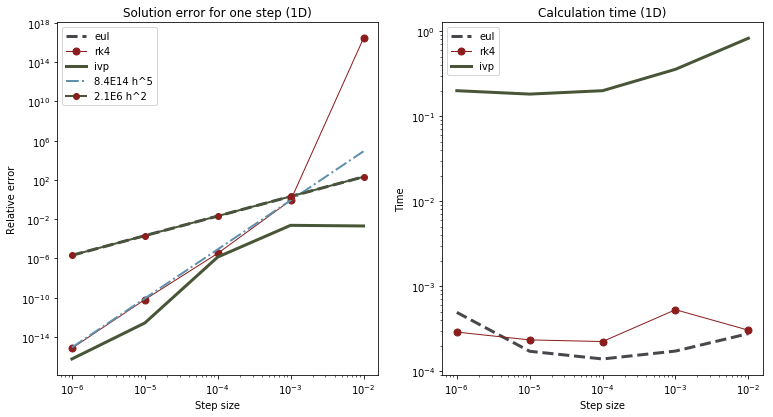

In [11]:
fig = plt.figure(**config['opts']['plot']['fig']['base_1_2'])
grd = mpl.gridspec.GridSpec(**config['opts']['plot']['grid']['base_1_2'])

ax1 = fig.add_subplot(grd[0, 0])
ax2 = fig.add_subplot(grd[0, 1])
ax1.plot(T_max, E_eul, **l1)
ax1.plot(T_max, E_rk4, **l2)
ax1.plot(T_max, E_ivp, **l3)

E_app = 8.4e+14 * T_max**5
l4['label'] = '8.4E14 h^5'
ax1.plot(T_max, E_app, **l4)

E_app = 2.1E+06 * T_max**2
l5['label'] = '2.1E6 h^2'
ax1.plot(T_max, E_app, **l5)

ax1.set_title('Solution error for one step (1D)')
ax1.set_xlabel('Step size')
ax1.set_ylabel('Relative error')
ax1.legend(loc='best')
ax1.semilogx()
ax1.semilogy()

ax2.plot(T_max, T_eul, **l1)
ax2.plot(T_max, T_rk4, **l2)
ax2.plot(T_max, T_ivp, **l3)
ax2.set_title('Calculation time (1D)')
ax2.set_xlabel('Step size')
ax2.set_ylabel('Time')
ax2.legend(loc='best')
ax2.semilogx()
ax2.semilogy()

plt.show()

<div class="head1">
    <div class="head1__name">
        Test 2D
    </div>
</div>

Consider
$$
    d r = f(r, t) \, d t,
    \quad
    r = (r_1, r_2) \in R^{2},
    \quad
    r(0) = r_0.
$$

Let set analytic solution
$$
    r_1(t) = \sin{2 t^2} + r_{0, 1},
    \quad
    r_2(t) = \cos{2 t^2} + r_{0, 2} - 1,
$$
then for the rhs we have
$$
    f_1(r, t) = 4 t \cos{2 t^2} = 4 t (r_2 - r_{0, 2} + 1),
    \quad
    f_2(r, t) = - 4 t \sin{2 t^2} = - 4 t (r_1 - r_{0, 1}).
$$

In [12]:
def func_f0(r, t, r0):
    v1 = +4. * t * (r[1, :] - r0[1, :] + 1.)
    v2 = -4. * t * (r[0, :] - r0[0, :])
    return np.vstack([v1, v2])

def func_rt(t):
    v1 = np.sin(2. * t * t) + r0[0, :]
    v2 = np.cos(2. * t * t) + r0[1, :] - 1.
    return np.vstack([v1, v2])

In [13]:
t_min = 0.
t_max = 0.001
t_poi = 2
r0 = np.vstack([
    np.arange(100) * 1.1 + 0.2,
    np.arange(100) * 1.5 + 0.3,
])

r_real = func_rt(t_max)

In [14]:
for name in names:
    _t = time.time()
    r_calc = eval('Solver.ode_solve_' + name)(func_f0, r0, t_min, t_max, t_poi, with_y0=True)
    _e = np.mean(np.abs((r_real - r_calc) / r_real))
    print('Solver: "%s" | Err: %-8.2e | Time: %-8.2e'%(name, _e, time.time() - _t))

Solver: "eul" | Err: 9.47e-08 | Time: 2.21e-04
Solver: "rk4" | Err: 2.98e-18 | Time: 5.73e-04
Solver: "ivp" | Err: 1.45e-17 | Time: 6.89e-02


In [18]:
T_max = np.array([1E-6, 1E-5, 1E-4, 1E-3, 1E-2, 1E-1])
T_rk4, E_rk4 = [], []
T_eul, E_eul = [], []
T_ivp, E_ivp = [], []

for name in names:
    for t_max in T_max:
        _t = time.time()
        r_calc = eval('Solver.ode_solve_' + name)(func_f0, r0, t_min, t_max, t_poi, with_y0=True)
        _r = func_rt(t_max)
        _e = np.mean(np.abs((_r - r_calc) / _r))
        eval('T_' + name).append(time.time() - _t)
        eval('E_' + name).append(_e)

In [19]:
print('--- Convergence orders')

x = T_max[:-1]
y = np.array(E_eul[:-1])
a, b = np.polyfit(x**2, y, 1)
print('eul : %-8.1e h^2 + %-8.1e'%(a, b))

x = T_max[:-1]
y = np.array(E_rk4[:-1])
a, b = np.polyfit(x**5, y, 1)
print('rk4 : %-8.1e h^5 + %-8.1e'%(a, b))

--- Convergence orders
eul : 9.5e-02  h^2 + 1.1e-11 
rk4 : 9.3e-08  h^5 + 3.0e-18 


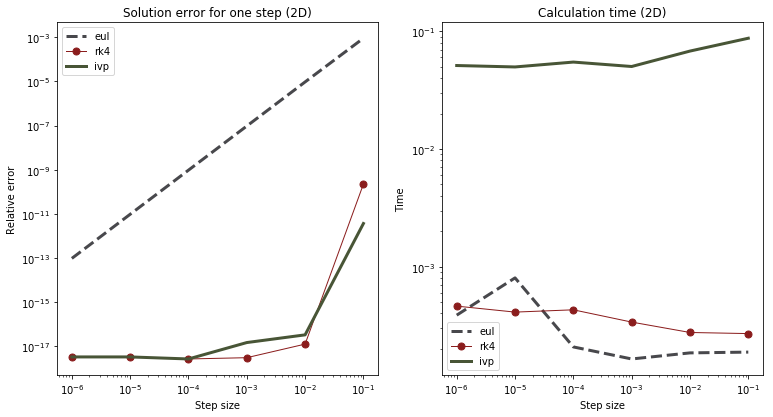

In [20]:
fig = plt.figure(**config['opts']['plot']['fig']['base_1_2'])
grd = mpl.gridspec.GridSpec(**config['opts']['plot']['grid']['base_1_2'])

ax1 = fig.add_subplot(grd[0, 0])
ax2 = fig.add_subplot(grd[0, 1])
ax1.plot(T_max, E_eul, **l1)
ax1.plot(T_max, E_rk4, **l2)
ax1.plot(T_max, E_ivp, **l3)

ax1.set_title('Solution error for one step (2D)')
ax1.set_xlabel('Step size')
ax1.set_ylabel('Relative error')
ax1.legend(loc='best')
ax1.semilogx()
ax1.semilogy()

ax2.plot(T_max, T_eul, **l1)
ax2.plot(T_max, T_rk4, **l2)
ax2.plot(T_max, T_ivp, **l3)
ax2.set_title('Calculation time (2D)')
ax2.set_xlabel('Step size')
ax2.set_ylabel('Time')
ax2.legend(loc='best')
ax2.semilogx()
ax2.semilogy()

plt.show()

<div class="end"></div>